In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
from dark import *
from wrn4 import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')
TRAIN = Path('train512/')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
seg_aug = pd.read_csv('../aug/augment.csv', header=None)
seg_aug.columns = seg.columns
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [3]:
len(seg),len(seg_aug)

(31072, 68093)

In [4]:
df = pd.merge(seg, seg_aug,'outer'); len(df)

99165

In [5]:
arch = Darknet([1,2,4,4,4], 28, 32, se=True);
# arch = wrn_22_10()

In [6]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.1, max_warp=0.4)

In [7]:
def get_data(sz=64, bs=64, pct=0.2, sample=5000):
#     sz, pct, bs = 64, 0.2, 64
    src = (ImageItemList.from_df(df=df, path=PATH, folder=TRAIN_AUG, suffix='.png')
           .random_split_by_pct(pct)
           .label_from_df(sep=' ', classes=classes)
           .add_test([TEST/(f+'.png') for f in test_names]))
    data = (src.transform(tfms, size=sz))
    #         .databunch(bs=bs).normalize(stats))

    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], num_samples=sample)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl, val_dl, test_dl).normalize(stats)

In [8]:
data = get_data()

In [9]:
data.classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27']

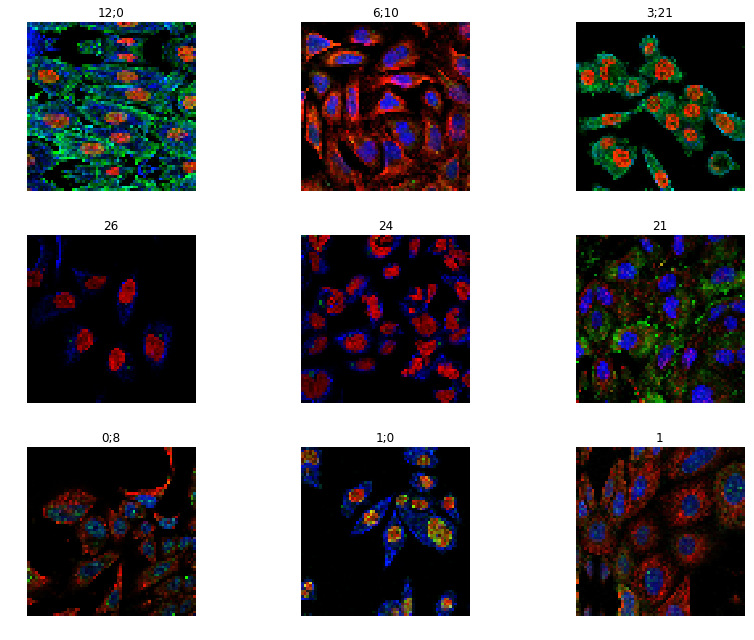

In [10]:
data.show_batch(rows=3, figsize=(12,9))

In [11]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1], 
                    callback_fns=[partial(GradientClipping, clip=0.1), ShowGraph])
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
    learn.split((arch.layers[11],arch.layers[20]))  #Split for 444 model [11,20]
    return learn.mixup(stack_y=False)

# 64

In [12]:
data = get_data(sz=64, bs=256, pct=0.1, sample=None)
learn = get_learner(data, focal=False, fp16=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


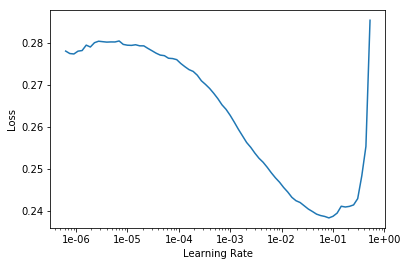

In [62]:
learn.lr_find()
learn.recorder.plot()

In [89]:
lr=5e-3

In [90]:
learn.load('dk3_444_se_64');

In [ ]:
%time learn.fit_one_cycle(20, lr, wd=0.3, div_factor=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.138809,0.118287,0.957806,0.312317
2,0.136375,0.106615,0.962503,0.318942
3,0.139225,0.148708,0.943187,0.224306


In [ ]:
learn.save('dk3_444_se_64')

# 128

In [ ]:
learn.data = get_data(sz=128, bs=64, pct=0.1, sample=None)
# learn = get_learner(data, focal=True, fp16=True)

In [ ]:
%time learn.fit_one_cycle(10, lr/3, wd=0.2, div_factor=10, pct_start=0.5)

In [ ]:
learn.save('dk3_444_se_128')

# 256

In [35]:
data = get_data(256, 36, 0.1, sample=None)

In [36]:
learn = get_learner(data, focal=True, fp16=True)

In [37]:
learn.load('dk3_444_se_256');

In [38]:
learn.freeze()

In [39]:
%time learn.fit_one_cycle(6, slice(1e-3), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 7:07:47
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.508146    0.508193    0.975981         0.484566  (1:11:33)
2      0.530358    0.547836    0.974442         0.468634  (1:11:16)
3      0.505009    0.527301    0.974835         0.472326  (1:11:09)
4      0.487390    0.502743    0.976189         0.486099  (1:11:15)
5      0.472985    0.473338    0.977302         0.497349  (1:11:16)
6      0.454378    0.472411    0.977140         0.499069  (1:11:16)

CPU times: user 4h 38min 28s, sys: 2h 28min 59s, total: 7h 7min 28s
Wall time: 7h 7min 47s


In [40]:
learn.save('dk3_444_se_256');

In [20]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(6, slice(1e-5, 1e-3), wd=0.3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,f1


In [23]:
learn.save('dk3_444_se_256');

In [38]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

## 512

In [13]:
data = get_data(512, 8, 0.01, sample = None)  #training with 512 size does not work.
learn = get_learner(data, focal=True, fp16=True)

In [26]:
learn.load('dk3_444_se_256');

In [27]:
learn.freeze()

In [14]:
%time learn.fit_one_cycle(1, slice(1e-3), wd=0.3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,f1


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/l

KeyboardInterrupt: 

In [15]:
learn.save('dk3_444_se_512');

In [16]:
learn.unfreeze()

In [17]:
%time learn.fit_one_cycle(1, slice(1e-5, 1e-3), div_factor=25, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,f1


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 7.43 GiB total capacity; 6.80 GiB already allocated; 32.94 MiB free; 84.21 MiB cached)

In [18]:
learn.save('dk3_444_se_512_2');

# Validation and Preds

In [68]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

Total time: 1:25:22



In [45]:
p.shape

torch.Size([11702, 28])

Compute optimal THS

In [79]:
#train data preds
learn.data.train_dl.add_tfm(to_half)
p_v, t_v = learn.get_preds(ds_type=DatasetType.Train)

KeyboardInterrupt: 

In [47]:
p_v_s = p_v.sigmoid()
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [60]:
ths = find_thresh(p_v_np, t_v_np); ths

array([0.44, 0.59, 0.44, 0.5 , 0.59, 0.49, 0.51, 0.5 , 0.95, 0.64, 0.64, 0.52, 0.69, 0.59, 0.59, 0.89, 0.77, 0.86,
       0.54, 0.47, 0.73, 0.43, 0.52, 0.45, 0.66, 0.42, 0.8 , 0.  ])

In [63]:
ths[-1]=0.4

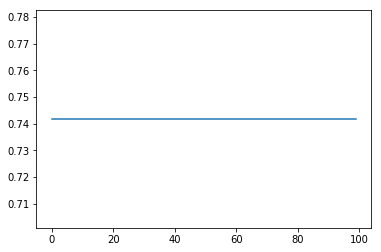

In [77]:
x = np.linspace(0,1,100)
y = np.array([f1_n(p_v_np, t_v_np, th, 27) for th in x])
plt.plot(y)

In [71]:
f1_np(p_v_np, t_v_np, ths)

0.7945772598891193

# Sub File

In [65]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = 0.4 #ths
print(preds.shape)
classes = np.array(data.classes)
# classes = array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
#        '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [66]:
classes

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '23', '24', '25', '26', '27'], dtype='<U2')

In [67]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_se.csv', index=False)

In [68]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 16 18
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,7
